In [430]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from flight.rosella import rosella
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
import sklearn.metrics as sk_metrics
import sklearn.cluster as sk_cluster
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from flight import metrics
import scipy.stats as sp_stats
from pynndescent import NNDescent
import umap
%matplotlib inline


In [431]:
filt = '/work2/microbiome/abisko/rhys/01-projects/02-anme/02-longreads/02.2-retentate/binning_testing/data/'

binner_filt = rosella.Rosella(count_path=filt+"coverm.cov", 
                                       kmer_frequencies=filt+"rosella_bins/rosella_kmer_table.tsv", 
                                       output_prefix=filt+"rosella_bins_second/", 
                                       assembly=filt+"final_contigs.fasta", min_contig_size=1500, threads=40, long_count_path=None, min_dist=0)

binner_filt.large_contigs.iloc[:, 5].mean()

11.533467417455311

In [432]:
def get_binner(filename, contigs, bin_folder):
    binner_filt = rosella.Rosella(count_path=filename+"coverm.cov", 
                                   kmer_frequencies=filename + "/" + bin_folder + "/rosella_kmer_table.tsv", 
                                   output_prefix=filename + "/" + bin_folder, 
                                   assembly=contigs, min_contig_size=1500, threads=40, long_count_path=None, min_dist=0)
    binner_filt.read_bin_file(filename + "/" + bin_folder + "/rosella_bins.json" )
    
    return binner_filt

In [433]:
def kmeans_cluster(binner, bin_id):
    tnf, agg, md, per_contig_avg = binner.bin_stats(bin_id)
    print(np.array(per_contig_avg)[binner.large_contigs[binner.large_contigs['tid'].isin(binner.bins[bin_id])]['contigLen'] > 1e6])
    contigs, log_lengths, tnfs = binner.extract_contigs(binner.bins[bin_id])
    distances = metrics.distance_matrix(np.concatenate((contigs.iloc[:, 3:].values, 
                                                        log_lengths.values[:, None], 
                                                        tnfs.iloc[:, 2:].values), axis=1), 2, 
                                        binner.short_sample_distance)
    kmeans = sk_cluster.KMeans(n_clusters=2, random_state=42069).fit(distances)
    print(sk_metrics.silhouette_score(distances, kmeans.labels_))
    return kmeans, np.array(per_contig_avg)

In [435]:
def gaussian_params(binner, check_size=None):
    log_lengths = np.log10(binner.large_contigs['contigLen'])
    # bandwidths = 10 ** np.linspace(-1, 1, 20)
    gm = GaussianMixture(n_components=2, random_state=42069, covariance_type='full').fit(log_lengths.values.reshape(-1, 1))

    idx25, n25 = binner.nX(25)
    n25 = min(n25, 150000)
    idx75, n75 = binner.nX(75)
    n75 = min(n75, 1000000)
    print(n25, n75)
    print(gm.means_)
    len(bandwidths)
    # Account for stochasticity by running a few times
    max_sum = 0
    min_sum = 0
    max_covar = 0
    min_covar = 0
    count = 0
    for i in range(10):
        gm = GaussianMixture(
            n_components=2,
            covariance_type='full'
        ).fit(log_lengths.values.reshape(-1, 1))
        max_sum += max(gm.means_)[0]
        max_covar += gm.covariances_[gm.means_.argmax()][0][0]
        min_sum += min(gm.means_)[0]
        min_covar += gm.covariances_[gm.means_.argmin()][0][0]

        count += 1

    max_mean = max_sum / count
    max_covar = max_covar / count
    min_mean = min_sum / count
    min_covar = min_covar / count
    print("Filtering Params - Max: %f, %f, %d Min: %f, %f, %d"
                 % (max_mean, max_covar, n75, max(min_mean, np.log10(5000)), min_covar, n25))
    
    if check_size is not None:
        skew_dist1 = sp_stats.skewnorm(np.log10(n25), max(min_mean, np.log10(5000)), 1 + min(max(min_covar, 0.01), 0.2))
        skew_dist2 = sp_stats.skewnorm(np.log10(n75), min(max_mean, 4.5), 1 + min(max(max_covar, 0.1), 0.2))
        prob1 = min(skew_dist1.pdf(np.log10(check_size)), 1.0)
        prob2 = min(skew_dist2.pdf(np.log10(check_size)), 1.0)
        prob = max(prob1, prob2)
        rho_thresh = min(max(prob / 2, 0.05), 1.0)
        euc_thresh = min(max(prob * 10, 1.0), 10)
        dep_thresh = min(max(prob / 2, 0.05), 1.0)
        print(dep_thresh, rho_thresh, euc_thresh)

In [77]:
kmeans, per_contig_avg = kmeans_cluster(binner_ret, 3000)

MAG size:  11167295
Mean TNF Rho:  0.06365230258559788
Mean Aitchinson:  3.4642396303325214
Mean Agg:  0.3194635484222923
Mean metabat:  0.14113374145244287
[[0.10378399 0.05513991 3.14974586 0.27830788]
 [0.11314788 0.05796515 3.13805759 0.292295  ]
 [0.18771439 0.05456223 3.11662189 0.34232056]]
0.12732888855386226


In [76]:
binner_ret.bins[3000] = list(binner_ret.large_contigs[binner_ret.large_contigs['tid'].isin(np.array(binner_ret.bins[118])[kmeans.labels_ == 1])]['tid'].values)

In [68]:
print(np.array(per_contig_avg)[binner_ret.large_contigs[binner_ret.large_contigs['tid'].isin(binner_ret.bins[122])]['contigLen'] > 5e3])
per_contig_avg[:, 3].max()

[[0.15274189 0.05747973 3.22672347 0.31730485]
 [0.16219213 0.05355867 3.13220011 0.32265386]
 [0.17766832 0.05981233 3.53378496 0.34181306]
 [0.16882494 0.10365032 4.04970241 0.36697527]
 [0.1861787  0.06823161 3.44363247 0.35625709]
 [0.16497543 0.05565242 3.34401693 0.32857142]
 [0.2082698  0.07063873 3.65304552 0.36958004]
 [0.28739301 0.07040332 3.89833106 0.41611666]
 [0.19071757 0.04612056 2.92563656 0.3356987 ]
 [0.3135329  0.06960884 3.56108193 0.42900434]
 [0.23652507 0.05508474 3.20427083 0.37468112]
 [0.21087844 0.06452565 3.29035449 0.36723055]
 [0.17164679 0.05883185 3.53847914 0.3340273 ]
 [0.16246643 0.08963603 4.69375099 0.35335829]
 [0.24457869 0.07770894 3.64910321 0.40061195]
 [0.19836593 0.07504693 3.53051813 0.37026265]
 [0.22121693 0.06246937 3.54878949 0.3715583 ]
 [0.19976048 0.05704875 3.30768932 0.35487454]
 [0.21154081 0.07328552 4.01823119 0.37528778]
 [0.16183156 0.06179144 3.45970114 0.32920028]
 [0.21991094 0.06779981 3.58884224 0.37816327]
 [0.2466254  

0.4307203009424506

In [84]:
sum(binner_ret.check_contigs(binner_ret.bins[118], 84))

0.2602762849776725 5.2055256995534505 0.2602762849776725
(True, True, True)


36

In [70]:
binner_cami_low = get_binner("/work2/microbiome/abisko/rhys/01-projects/09-simulated_metagenomes/03-CAMI_one/00-low_complexity/binning/data/", 
                 "/work2/microbiome/abisko/rhys/01-projects/09-simulated_metagenomes/03-CAMI_one/00-low_complexity/binning/final_gold_standard.fasta",
                "rosella_bins")
gaussian_params(binner_cami_low)

# current best, 0.3 (1.9, 1.8): 17, 20, 22, 22, 22

56348 371895
[[4.54825922]
 [3.49106162]]
Filtering Params - Max: 4.549472, 0.331093, 371895 Min: 3.698970, 0.048862, 56348


In [71]:
binner_cami_med = get_binner("/work2/microbiome/abisko/rhys/01-projects/09-simulated_metagenomes/03-CAMI_one/01-med_complexity/binning/data/", 
                 "/work2/microbiome/abisko/rhys/01-projects/09-simulated_metagenomes/03-CAMI_one/01-med_complexity/binning/gold_standard.fasta",
                "rosella_bins")
gaussian_params(binner_cami_med)


# current best, 0.3 1.5: 92, 96, 97, 98, 100

140190 717233
[[5.00290228]
 [3.91252842]]
Filtering Params - Max: 5.008187, 0.238702, 717233 Min: 3.918083, 0.197634, 140190


In [36]:
binner_cami_hi = get_binner("/work2/microbiome/abisko/rhys/01-projects/09-simulated_metagenomes/03-CAMI_one/02-hi_complexity/binning/data/", 
                 "/work2/microbiome/abisko/rhys/01-projects/09-simulated_metagenomes/03-CAMI_one/02-hi_complexity/binning/hungry_colden.fasta",
                "rosella_bins")
# gaussian_params(binner_cami_hi)
binner_cami_hi.filter()
kmer_signature = binner_cami_hi.tnfs[~binner_cami_hi.disconnected].iloc[:, 2:].values
coverage_profile = binner_cami_hi.large_contigs[~binner_cami_hi.disconnected].iloc[:, 3:].values

In [4]:
binner_ret = get_binner("/work2/microbiome/abisko/rhys/01-projects/02-anme/02-longreads/02.2-retentate/binning_testing/data/", 
                 "/work2/microbiome/abisko/rhys/01-projects/02-anme/02-longreads/02.2-retentate/binning_testing/data/final_contigs.fasta",
                "rosella_bins_second")
gaussian_params(binner_ret, [603])
# binner_ret.filter()


In [5]:
sum(binner_ret.disconnected)

3795

In [5]:
import scipy.spatial.distance as sp_distance
import flight.metrics as metrics
import flight.distance as distance

In [37]:
euc = sp_distance.pdist(coverage_profile, metric="euclidean")

In [33]:
euc = euc.argsort()
euc = euc.argsort()

In [34]:
euc

array([ 1479, 16637,  6711, ..., 42851, 64335, 14971])

In [32]:
cov_ranks

array([2.30619538e+14, 2.55876084e+16, 1.72222128e+15, ...,
       1.04565589e+16, 2.45995006e+16, 2.00864391e+16])

In [6]:
kmer_signature = binner_filt.tnfs[~binner_filt.disconnected].iloc[:, 2:].values
coverage_profile = binner_filt.large_contigs[~binner_filt.disconnected].iloc[:, 3:].values
contigLengths = binner_filt.large_contigs["contigLen"].values
n = len(contigLengths)
weights = np.empty(n * (n - 1) // 2, dtype=np.double)
k = 0
for i in range(n - 1):
    weights[k:(k + n - 1 - i)] = contigLengths[i] * contigLengths[(i + 1):n]
    k = k + n - 1 - i
weight_fun = lambda i: weights[i]
cov_ranks = distance.argrank(sp_distance.pdist(coverage_profile, metrics.coverage_distance), weight_fun=weight_fun)
kmer_ranks = distance.argrank(sp_distance.pdist(kmer_signature, metric="euclidean"), weight_fun=weight_fun)
rho_ranks = distance.argrank(sp_distance.pdist(kmer_signature, metrics.rho), weight_fun=weight_fun)

In [89]:
# cov_ranks
# kmer_ranks
dists = (cov_ranks / max(cov_ranks)) * (kmer_ranks / max(kmer_ranks)) * (rho_ranks / max(rho_ranks))

In [84]:
dists

array([0.01427584, 0.52178602, 0.07034228, ..., 0.09713632, 0.28131305,
       0.14627945])

In [1]:
import hdbscan
import umap

precomputed_reducer1 = umap.UMAP(
            metric="precomputed",
            n_neighbors=100,
            n_components=2,
            min_dist=1,
            set_op_mix_ratio=1,
            a=1.48,
            b=0.4,
            init="spectral",
            random_state=420,
            parallel=False
        )

precomputed_reducer2 = umap.UMAP(
            metric="precomputed",
            n_neighbors=100,
            n_components=2,
            min_dist=1,
            set_op_mix_ratio=1,
            a=1.48,
            b=0.4,
            init="spectral",
            random_state=69,
            parallel=False
        )


precomputed_reducer1.fit(sp_distance.squareform(dists))
precomputed_reducer2.fit(sp_distance.squareform(dists))



TypeError: __init__() got an unexpected keyword argument 'parallel'

In [428]:
precomputed_reducer1.embedding_

array([[ 5.313142 ,  4.6954174],
       [16.322561 , 17.173803 ],
       [10.740486 , 11.360741 ],
       ...,
       [ 6.556292 , 22.717693 ],
       [11.035285 , 11.596063 ],
       [11.312569 , 12.015923 ]], dtype=float32)

In [429]:
precomputed_reducer2.embedding_

array([[18.788149 , -9.593342 ],
       [-0.1800924,  1.8270459],
       [ 4.6076765, -1.9214635],
       ...,
       [ 5.4163117, 13.6290455],
       [ 6.888256 , 10.540151 ],
       [ 7.11112  , 10.731738 ]], dtype=float32)

In [143]:
import ClusterEnsembles as CE
from flight.rosella.clustering import Clusterer

def get_cluster_labels_array(
    distances,
    metric="euclidean",
    cluster_selection_methods=["eom"],
    top_n=3,
    # min_sizes = [2, 4, 6, 8, 10],
    # min_samples = [3, 6, 9, 12],
    solver="hbgf",
    threads=16,
    embeddings_for_precomputed=None
):
    """
    Uses cluster ensembling with ClusterEnsembles package to produce partitioned set of
    high quality clusters from multiple HDBSCAN runs
    Takes top N clustering results and combines them
    solver - one of {'cspa', 'hgpa', 'mcla', 'hbgf', 'nmf', 'all'}, default='hbgf'
    """
    label_array = np.array([np.array([-1 for _ in range(distances.shape[0])]) for _ in range(top_n)])
    best_min_size = np.array([None for _ in range(top_n)])
    best_min_sample = np.array([None for _ in range(top_n)])
    best_selection_method = np.array([None for _ in range(top_n)])
    best_validity = np.array([None for _ in range(top_n)])
    index = 0
    for min_size in range(3, 10):
        for min_sample in range(5, 10):
            for selection_method in cluster_selection_methods:
                clusterer = hdbscan.HDBSCAN(
                    algorithm='best',
                    alpha=1.0,
                    cluster_selection_method=selection_method,
                    metric=metric,
                    min_cluster_size=min_size,
                    min_samples=min_sample,
                    core_dist_n_jobs=threads,
                    approx_min_span_tree=False
                )
                clusterer.fit(distances)

                try:
                    if metric != "precomputed":
                        cluster_validity = Clusterer.validity(
                            clusterer.labels_, distances, quick=True
                        )
                    else:
                        cluster_validity = Clusterer.validity(
                            clusterer.labels_, embeddings_for_precomputed, quick=True
                        )
                except (ValueError, FloatingPointError):
                    try:
                        if metric != "precomputed":
                            cluster_validity = Clusterer.validity(
                                clusterer.labels_, distances, quick=False
                            )
                        else:
                            cluster_validity = Clusterer.validity(
                                clusterer.labels_, embeddings_for_precomputed, quick=False
                            )
                    except (ValueError, FloatingPointError):
                        cluster_validity = -1

                if np.any(best_validity == None):
                    best_min_size[index] = min_size
                    best_min_sample[index] = min_sample
                    best_selection_method[index] = selection_method
                    best_validity[index] = cluster_validity
#                     clusterer.labels_ = clusterer.labels_.astype(np.float32)
#                     clusterer.labels_[clusterer.labels_ == -1] = np.nan
                    label_array[index] = clusterer.labels_
                    index += 1

                    if index == top_n:

                        # sort the current top by ascending validity order
                        ranks = np.argsort(best_validity)
                        best_validity = best_validity[ranks]
                        best_min_sample = best_min_sample[ranks]
                        best_min_size = best_min_size[ranks]
                        best_selection_method = best_selection_method[ranks]
                        label_array = label_array[ranks]
                        # with np.set_printoptions(precision=3, suppress=True, formatter={'float': '{: 0.3f}'.format}):
                        print(best_validity)
                        print(label_array)
#                         return label_array
                    
                elif np.any(best_validity < cluster_validity):
                    # insert the new result and remove the worst result
                    ind = np.searchsorted(best_validity, cluster_validity)
                    best_validity = np.insert(best_validity, ind, cluster_validity)[1:]
                    best_min_size = np.insert(best_min_size, ind, min_size)[1:]
                    best_min_sample = np.insert(best_min_sample, ind, min_sample)[1:]
                    best_selection_method = np.insert(best_selection_method, ind, selection_method)[1:]
#                     clusterer.labels_ = clusterer.labels_.astype(np.float32)
#                     clusterer.labels_[clusterer.labels_ == -1] = np.nan
                    label_array = np.insert(label_array, ind, clusterer.labels_, axis=0)[1:]

#     # logging.info("Found %d potential cluster configurations..." % len(label_array))
#     if len(label_array) >= 1:
#         try:
#             label_ce = CE.cluster_ensembles(label_array, solver=solver)
#         except FloatingPointError:
#             label_ce = CE.cluster_ensembles(label_array, solver='hbgf')
#     else:
#         # if all else fails, just take the best label result
#         label_ce = label_array[-1]
    print(best_validity)
    return label_array, best_validity

In [154]:
def ensemble_cluster_multiple_embeddings(
        embeddings_array,
        metric="euclidean",
        cluster_selection_methods=["eom"],
        top_n=3,
        # min_sizes = [2, 4, 6, 8, 10],
        # min_samples = [3, 6, 9, 12],
        solver="hbgf",
        threads=16,
        embeddings_for_precomputed=None
):
    """
    Uses cluster ensembles to find best results across multiple different embeddings
    and clustering results.
    embeddings_array - an array of n different embeddings of distance matrix
    """
    if metric == "precomputed":
        if len(embeddings_for_precomputed) != len(embeddings_array):
            sys.exit("Require reduced embeddings via UMAP or other method in addition to precomputed distance matrix")
    else:
        embeddings_for_precomputed = [None for _ in range(len(embeddings_array))]

    best_clusters = np.array([np.array([-1 for _ in range(embeddings_array[0].shape[0])]) for _ in range(top_n * len(embeddings_array))])
    best_validities = np.array([np.nan for _ in range(top_n * len(embeddings_array))])

    stored_index = 0
    for idx, embeddings in enumerate(embeddings_array):

        label_results, label_validities = get_cluster_labels_array(
            embeddings,
            metric,
            cluster_selection_methods,
            top_n,
            solver,
            threads,
            embeddings_for_precomputed[idx]
        )
        for result_index in range(label_results.shape[0]):
            best_clusters[stored_index] = label_results[result_index]
            best_validities[stored_index] = label_validities[result_index]
            stored_index += 1

    ranks = np.argsort(best_validities)
    best_validities = best_validities[ranks]
    best_clusters = best_clusters[ranks]
    # best_clusters = np.array(best_clusters)
    # unclustered = np.all(best_clusters == -1, axis=0)
    # label_ensemble = CE.cluster_ensembles(best_clusters)
    # label_ensemble[unclustered] = -1

    return best_clusters, best_validities

In [67]:
test = np.array([clusterer1.labels_, clusterer2.labels_])
test

array([[-1, 56, -1, ..., -1, -1, -1],
       [-1, 34, -1, ..., -1, -1, -1]])

In [141]:

# labels_ce = CE.cluster_ensembles(get_cluster_labels_array(precomputed_reducer1.embedding_))
# print(hdbscan.validity.validity_index(precomputed_reducer1.embedding_, labels_ce, metric="euclidean", d=2))
# labels_array = get_cluster_labels_array(precomputed_reducer1.embedding_)
# labels_array.tolist()
print(np.all(labels_array == -1, axis = 0))
print(labels_array[-1])

[ True False  True ... False False False]
[ -1  99  -1 ... 111 105  93]


In [160]:
labels = labels_array[-1]
labels[labels != -1] += 5
labels

array([ -1, 124,  -1, ..., 136, 130, 118])

In [155]:
label_ensemble, best_clusters = ensemble_cluster_multiple_embeddings([precomputed_reducer1.embedding_, precomputed_reducer2.embedding_], metric="euclidean", embeddings_for_precomputed=[precomputed_reducer1.embedding_])
# label_ensemble[label_ensemble == np.nan] == -1
# label_ensemble = label_ensemble.astype(np.int32)
# np.all(np.array(best_clusters) == -1, axis=0)
best_clusters

[0.543488198707406 0.553770799155221 0.5660324584248568]
[[ 16 108  94 ... 115 121 113]
 [ -1 115 114 ... 129 136  -1]
 [ 13  94  -1 ... 102 105  98]]
[0.598738141371567 0.6001474042383078 0.6004209374962594]
[0.5395584360807372 0.5655769845708885 0.594649120485504]
[[ 22  97  -1 ...  -1 130 134]
 [ 22  84  -1 ...  -1 110 132]
 [ 22  79  -1 ...  -1 103 111]]
[0.6276835847762228 0.6304643694597597 0.6344290212639457]


array([0.59873814, 0.6001474 , 0.60042094, 0.62768358, 0.63046437,
       0.63442902])

In [153]:
label_ensemble[-1]
best_clusters

array([nan, nan, nan, nan, nan, nan])

In [147]:
Clusterer.validity(
                        label_ensemble[-1], precomputed_reducer1.embedding_, quick=True
                    )

0.5709219866654923

In [116]:
label_ensemble[label_ensemble == -1]

array([], dtype=int32)

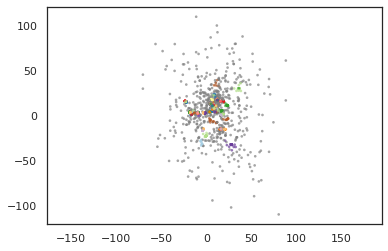

In [138]:
import sklearn.datasets
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

color_palette = sns.color_palette('Paired', max(label_ensemble) + 1)
cluster_colors = [
    color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in label_ensemble
]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(precomputed_reducer1.embedding_[:, 0],
           precomputed_reducer1.embedding_[:, 1],
           s=7,
           linewidth=0,
           c=cluster_colors,
           alpha=0.7)
plt.gca().set_aspect('equal', 'datalim')
plt.show()

In [74]:
binner_filt = get_binner("/work2/microbiome/abisko/rhys/01-projects/02-anme/02-longreads/01.1-filtrate/binning_testing_80/data/", 
                 "/work2/microbiome/abisko/rhys/01-projects/02-anme/02-longreads/01.1-filtrate/binning_testing_80/data/final_contigs.fasta",
                "rosella_bins")
gaussian_params(binner_filt)


# current best, 0.3 1.5: 4, 9, 9, 10, 17

25313 670374
[[4.36689715]
 [3.74136746]]
Filtering Params - Max: 4.366372, 0.118625, 670374 Min: 3.733640, 0.154629, 25313


7356.100319150057 0.6445414127615237


<Figure size 1800x1200 with 0 Axes>

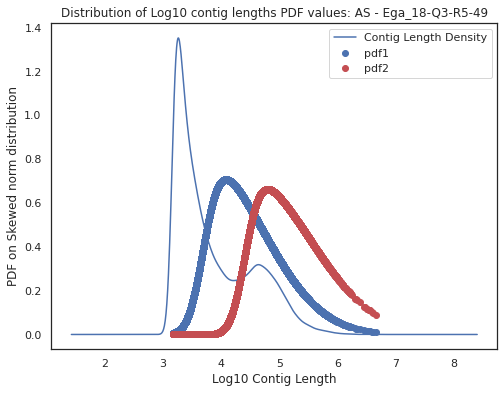

In [419]:
# binner_ega = get_binner("/lustre/scratch/microbiome/n10853499/00-rosella_testing/02-activated_sludge/assembly/Ega_18-Q3-R5-49/data/", 
#                  "/lustre/scratch/microbiome/n10853499/00-rosella_testing/02-activated_sludge/assembly/Ega_18-Q3-R5-49/assembly/final_contigs.fasta",
#                 "rosella_bins")
# log_lengths = np.log10(binner_ega.large_contigs['contigLen'])
# # bandwidths = 10 ** np.linspace(-1, 1, 20)
# gm = GaussianMixture(n_components=2, random_state=42069, covariance_type='full').fit(log_lengths.values.reshape(-1, 1))

# idx25, n25 = binner_ega.nX(25)
# idx75, n75 = binner_ega.nX(75)
# print(n25, n75)
# print(gm.means_)
# # len(bandwidths)
# # Account for stochasticity by running a few times
# max_sum = 0
# min_sum = 0
# max_covar = 0
# min_covar = 0
# count = 0
# for i in range(10):
#     gm = GaussianMixture(
#         n_components=2,
#         covariance_type='full'
#     ).fit(log_lengths.values.reshape(-1, 1))
#     max_sum += max(gm.means_)[0]
#     max_covar += gm.covariances_[gm.means_.argmax()][0][0]
#     min_sum += min(gm.means_)[0]
#     min_covar += gm.covariances_[gm.means_.argmin()][0][0]

#     count += 1

# max_mean = max_sum / count
# max_covar = max_covar / count
# min_mean = min_sum / count
# min_covar = min_covar / count
# print("Filtering Params - Max: %f, %f, %d Min: %f, %f, %d"
#              % (max_mean, max_covar, n75, max(min_mean, np.log10(5000)), min_covar, n25))

# dist1 = sp_stats.skewnorm(np.log10(n25), max(min_mean, np.log10(5000)), 1 + max(min_covar / count, 0.01))
# dist2 = sp_stats.skewnorm(np.log10(n75), max_mean, 1 + max(max_covar / count, 0.1))
from matplotlib.pyplot import figure
import pandas as pd

figure(figsize=(6, 4), dpi=300)     
prob1 = dist1.pdf(log_lengths)
prob2 = dist2.pdf(log_lengths)
plt.figure()
# plt.hist(log_lengths.values.reshape(-1, 1), bins=100)
pd.Series(log_lengths).plot(kind='density', label="Contig Length Density")
plt.plot(log_lengths, prob1, color='b', marker='o', linestyle='none', label="pdf1")
plt.plot(log_lengths, prob2, color='r', marker='o', linestyle='none', label="pdf2")
plt.xlabel("Log10 Contig Length")
plt.ylabel("PDF on Skewed norm distribution")


plt.title("Distribution of Log10 contig lengths PDF values: AS - Ega_18-Q3-R5-49")


plt.legend(loc="upper right")
# plt.show()

fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.savefig('gmm_example.svg', dpi=600)
print(10**log_lengths.mean(), log_lengths.std())

In [86]:
binner_camit_uro = get_binner("/lustre/scratch/microbiome/n10853499/00-rosella_testing/01-CAMI_II/CAMI_uro/binning/sample_2/data/", 
                 "/lustre/scratch/microbiome/n10853499/00-rosella_testing/01-CAMI_II/CAMI_uro/hybrid/sample_2/anonymous_gsa.fasta",
                "rosella_bins")
gaussian_params(binner_camit_uro, 2326295)


150000 1000000
[[3.60904804]
 [5.06331841]]
Filtering Params - Max: 5.063318, 0.893359, 1000000 Min: 3.698970, 0.065377, 150000
0.09914873357503759 0.09914873357503759 1.982974671500752


In [22]:
sp_stats.mstats.gmean(log_lengths)
dist = sp_stats.skewnorm(np.log10(n25), log_lengths.mean(), 1)

In [182]:
np.random.randint(0, 1000000)

310545

# KNN testing

In [383]:
from flight import metrics
from umap.umap_ import nearest_neighbors

contigs, ll, tnfs = binner_ret.extract_contigs(binner_ret.large_contigs['tid'].values[0:200])
current = np.concatenate((contigs.iloc[:, 3:].values, ll.values[:, None], tnfs.iloc[:, 2:].values), axis=1)
tnfs = np.concatenate((ll.values[:, None], tnfs.iloc[:, 2:].values), axis=1)

In [384]:
%%time
index_rho = NNDescent(tnfs, metric=metrics.rho, n_neighbors=5)
# index_rho = nearest_neighbors(tnfs, metric=metrics.rho, n_neighbors=30, metric_kwds=None, angular=False, random_state=None)

CPU times: user 680 ms, sys: 1.29 s, total: 1.97 s
Wall time: 150 ms


In [385]:
%%time
index_euc = NNDescent(tnfs, metric=metrics.tnf_euclidean, n_neighbors=5)
# index_euc = nearest_neighbors(tnfs, metric=metrics.tnf_euclidean, n_neighbors=30, metric_kwds=None, angular=False, random_state=None)

CPU times: user 411 ms, sys: 185 ms, total: 597 ms
Wall time: 113 ms


In [312]:
%%time
index_md = NNDescent(current, metric=metrics.metabat_distance, n_neighbors=5)
# index_md = nearest_neighbors(current, metric=metrics.aggregate_tnf, metric_kwds={"n_samples": binner_ret.n_samples, "sample_distances": binner_ret.short_sample_distance}, n_neighbors=30, angular=False, random_state=None)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function lt>) found for signature:
 
 >>> lt(list(float64)<iv=None>, float32)
 
There are 20 candidate implementations:
[1m     - Of which 18 did not match due to:
     Overload of function 'lt': File: <numerous>: Line N/A.
       With argument(s): '(list(float64)<iv=None>, float32)':[0m
[1m      No match.[0m
[1m     - Of which 2 did not match due to:
     Operator Overload in function 'lt': File: unknown: Line unknown.
       With argument(s): '(list(float64)<iv=None>, float32)':[0m
[1m      No match for registered cases:
       * (bool, bool) -> bool
       * (int8, int8) -> bool
       * (int16, int16) -> bool
       * (int32, int32) -> bool
       * (int64, int64) -> bool
       * (uint8, uint8) -> bool
       * (uint16, uint16) -> bool
       * (uint32, uint32) -> bool
       * (uint64, uint64) -> bool
       * (float32, float32) -> bool
       * (float64, float64) -> bool[0m
[0m
[0m[1mDuring: typing of intrinsic-call at /home/n10853499/.conda/envs/rosella/lib/python3.8/site-packages/pynndescent/pynndescent_.py (79)[0m
[1m
File "../../.conda/envs/rosella/lib/python3.8/site-packages/pynndescent/pynndescent_.py", line 79:[0m
[1mdef generate_leaf_updates(leaf_block, dist_thresholds, data, dist):
    <source elided>
                d = dist(data[p], data[q])
[1m                if d < dist_thresholds[p] or d < dist_thresholds[q]:
[0m                [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function generate_leaf_updates at 0x7eea335c4310>))[0m
[0m[1mDuring: typing of call at /home/n10853499/.conda/envs/rosella/lib/python3.8/site-packages/pynndescent/pynndescent_.py (99)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function generate_leaf_updates at 0x7eea335c4310>))[0m
[0m[1mDuring: typing of call at /home/n10853499/.conda/envs/rosella/lib/python3.8/site-packages/pynndescent/pynndescent_.py (99)
[0m
[1m
File "../../.conda/envs/rosella/lib/python3.8/site-packages/pynndescent/pynndescent_.py", line 99:[0m
[1mdef init_rp_tree(data, dist, current_graph, leaf_array):
    <source elided>

[1m        updates = generate_leaf_updates(leaf_block, dist_thresholds, data, dist)
[0m        [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function init_rp_tree at 0x7eea335c4940>))[0m
[0m[1mDuring: typing of call at /home/n10853499/.conda/envs/rosella/lib/python3.8/site-packages/pynndescent/pynndescent_.py (339)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function init_rp_tree at 0x7eea335c4940>))[0m
[0m[1mDuring: typing of call at /home/n10853499/.conda/envs/rosella/lib/python3.8/site-packages/pynndescent/pynndescent_.py (339)
[0m
[1m
File "../../.conda/envs/rosella/lib/python3.8/site-packages/pynndescent/pynndescent_.py", line 339:[0m
[1mdef nn_descent(
    <source elided>
        if rp_tree_init:
[1m            init_rp_tree(data, dist, current_graph, leaf_array)
[0m            [1m^[0m[0m


In [ ]:
dep = umap.UMAP(n_neighbors = 100, n_components = 2, metric=metrics.aggregate_tnf, metric_kwds={"n_samples": binner_ret.n_samples, "sample_distances": binner_ret.short_sample_distance})

In [44]:
precomputed_dep = []
precomputed_rho = []
precomputed_tnf = []
combined = []

a = [1.0, 1.25, 1.5, 1.75, 2.0]
b = [0.3, 0.4, 0.5, 0.6, 0.7]
# m = []

for a1, b1 in zip(a, b):
    dep = umap.UMAP(
        n_neighbors = 100, 
        n_components = 2,
        metric=metrics.aggregate_tnf, 
        metric_kwds={"n_samples": binner_ret.n_samples, "sample_distances": binner_ret.short_sample_distance},
        a=a1,
        b=b1,
        precomputed_knn = index_md
    ).fit(current)
    precomputed_dep.append(dep)
    
    rho = umap.UMAP(
        n_neighbors = 100, 
        n_components = 2,
        metric=metrics.rho,
        a=a1,
        b=b1,
        precomputed_knn = index_rho
    ).fit(tnfs)
    precomputed_rho.append(rho)
    
    tnf = umap.UMAP(
        n_neighbors = 100, 
        n_components = 2,
        metric=metrics.tnf_euclidean,
        a=a1,
        b=b1,
        precomputed_knn = index_euc
    ).fit(tnfs)
    precomputed_tnf.append(tnf)
    
    combined.append(dep + tnf + rho)
    

/home/n10853499/.conda/envs/rosella/lib/python3.8/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
/home/n10853499/.conda/envs/rosella/lib/python3.8/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
/home/n10853499/.conda/envs/rosella/lib/python3.8/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
/home/n10853499/.conda

In [380]:
index_rho._neighbor_graph[0][100, :]
net = np.zeros((index_euc._neighbor_graph[0].shape[0], index_euc._neighbor_graph[0].shape[0]))
net[index_euc._neighbor_graph[0][:,1:] - 1, index_euc._neighbor_graph[0][:,1:] - 1] = 1

In [357]:
def convert_to_adjacency(matrix):
    start = 0
    res = []
    lst = []
    n = len(matrix)

    for i in range(n):
        res.append(lst*n)
    while start < n:
        y = matrix[start]
        for i in range(len(y)):
            if y[i] == 1:
                res[start].append(i)
        start += 1
    return res

def convert_to_matrix(graph):
    matrix = []
    for i in range(len(graph)): 
        matrix.append([0]*len(graph))
        for j in graph[i]:
            matrix[i][j] = 1
    return matrix

In [370]:
for row in range(index_euc._neighbor_graph[0].shape[0]):
    net[row, index_euc._neighbor_graph[0][row,1:]] = 1

[177 343 256  96 464 439  68 432 435 138 103  52  59 392  92 151 434 466
  31  69  94 442 105 444  70  73 459 174  56]
[  4  64 365 230 478 185 282  65 214  82 149   5 193  12 203 235 154 389
 135 102 336   6 226 259 106 129 258 269 387]
[ 99  89 346 338 475  91 178 415 260  98 280 357 470 270   9 245 143 393
 153 306 341 488 335 350 250 413 158 484  83]
[  6  82 478   4   1 282  64 236 149 185  12 230 214 203 211 389 365 154
 102 135 226 235 224 269  65 106 363   5 258]
[478   1 230 235  65 185  64 365 149 214 154 282   5 203 193  82  12 135
 325 269   9 143 102 106 389 226 217 224 259]
[193   4  65 230 478 235 149 154 185  82  64 203   1 365 325 224 282 214
   6 269 205 259   9 336  12 258 109 324 129]
[ 82 236 230 282 203 478 224 185   5   4   1 214 149  64 193 129 258 389
 365 269 235 154  12 259 109 181 205  65  63]
[ 71  72  75  77  57  74  73 459  70 379  69 291 304 184 352 425 354 398
 321  46  47 426  55 423  59  51 349 353 168]
[289  17  88 131 312 447 332 241 107 408 331 406

In [373]:
net[0, 343]

1.0

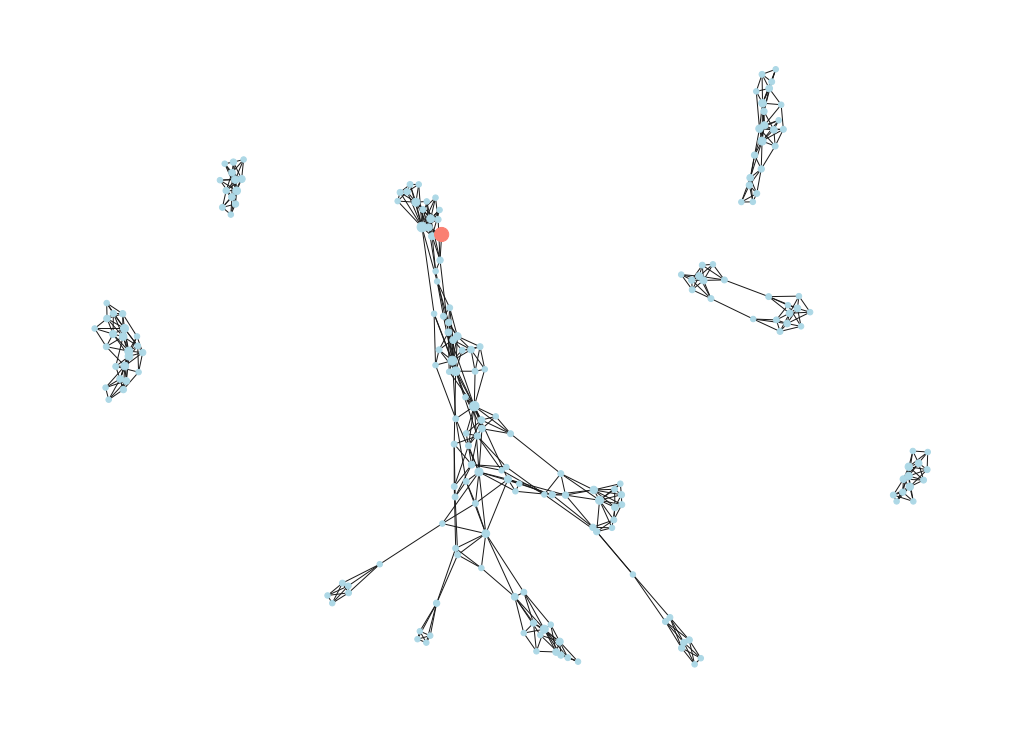

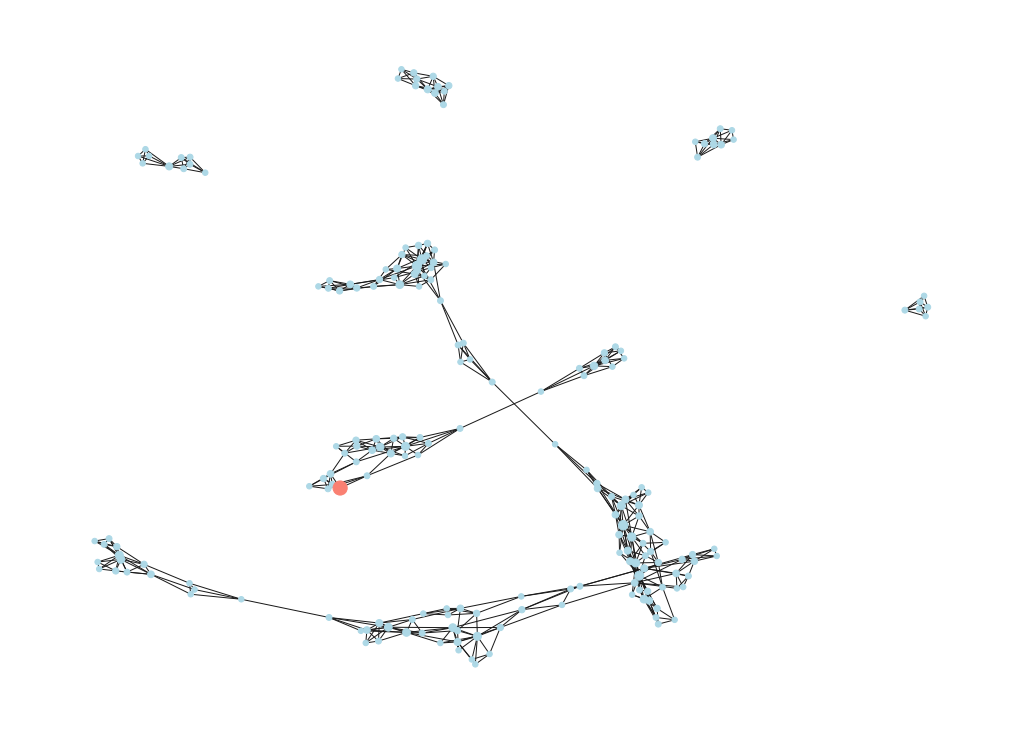

In [417]:
import networkx as nx
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

net = np.zeros((index_euc._neighbor_graph[0].shape[0], index_euc._neighbor_graph[0].shape[0]))
for row in range(index_euc._neighbor_graph[0].shape[0]):
    net[row, index_euc._neighbor_graph[0][row,1:]] = 1
    
np.fill_diagonal(net, 0)   
G = nx.convert_matrix.from_numpy_array(net)
colors = [['lightblue', 'salmon'][node == 100] 
              for node in G.nodes()]
labels = {node: ['', 'Target'][node == 100] 
          for node in G.nodes()}
pos = nx.spring_layout(G)
d = dict(G.degree)
sizes = [[d[node]*5 + 10, 200][node == 100] for node in G.nodes()]
nx.draw(G, pos, 
#         with_labels=True, 
        nodelist=d, 
        node_size=sizes,
#         labels=labels,
        node_color=colors)
plt.savefig("retentate_graph_euc.svg", format="SVG")
plt.show()

net = np.zeros((index_rho._neighbor_graph[0].shape[0], index_rho._neighbor_graph[0].shape[0]))
for row in range(index_rho._neighbor_graph[0].shape[0]):
    net[row, index_rho._neighbor_graph[0][row,1:]] = 1

np.fill_diagonal(net, 0)   

G = nx.convert_matrix.from_numpy_array(net)
colors = [['lightblue', 'salmon'][node == 100] 
              for node in G.nodes()]

labels = {node: ['', 'Target'][node == 100] 
          for node in G.nodes()}
pos = nx.spring_layout(G)
d = dict(G.degree)
sizes = [[d[node]*5 + 10, 200][node == 100] for node in G.nodes()]
nx.draw(G, pos, 
#         with_labels=True, 
        nodelist=d, 
        node_size=sizes,
#         labels=labels,
        node_color=colors)
plt.savefig("retentate_graph_rho.svg", format="SVG")
plt.show()
    

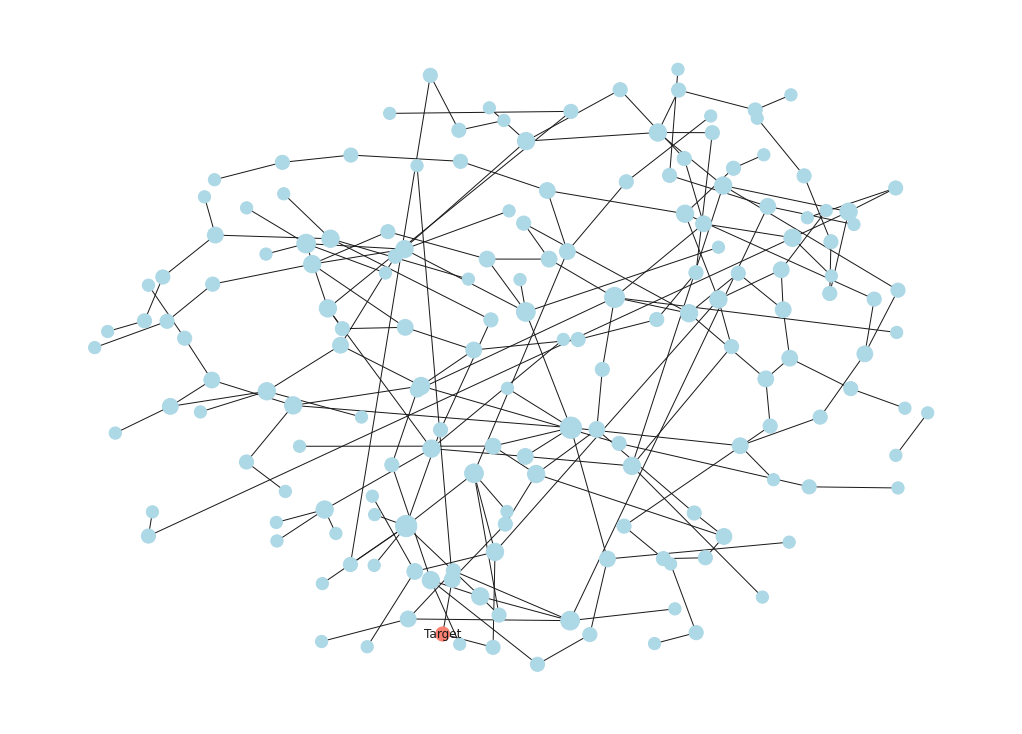

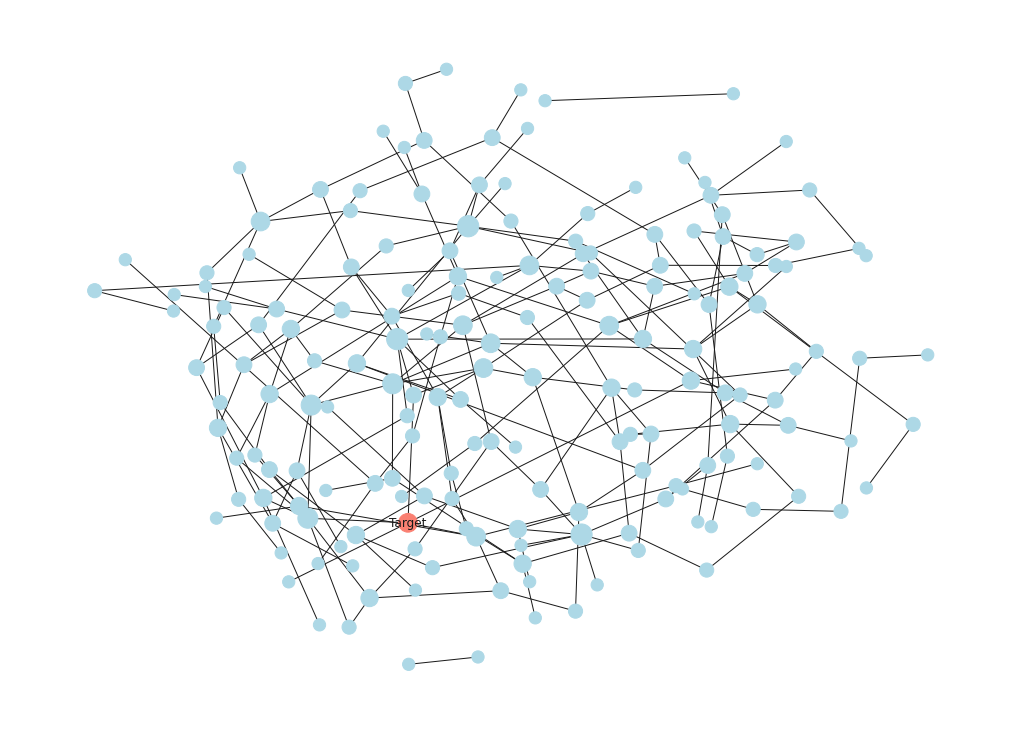

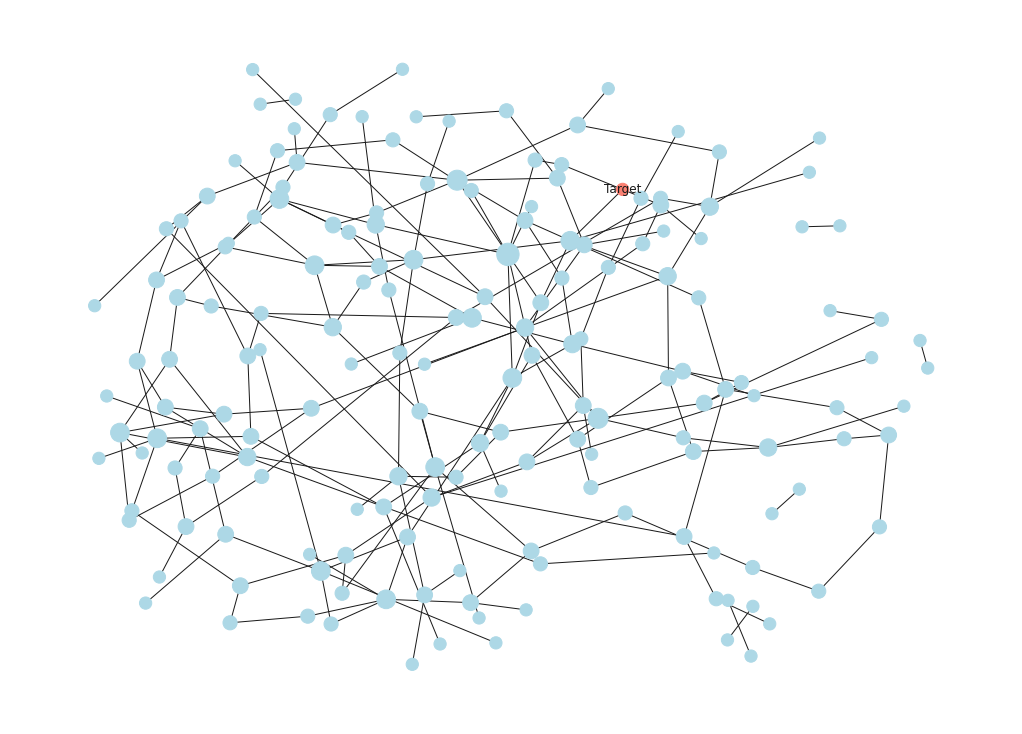

In [309]:
from pylab import rcParams
import random
rcParams['figure.figsize'] = 14, 10

for index in range(3):
    G = nx.fast_gnp_random_graph(200, 0.1)
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.random()
    cutoff = 0.1
    top = [edge for edge in G.edges(data=True) 
           if edge[2]['weight'] < cutoff]

    G = nx.MultiGraph(top)

    # pos = nx.random_layout(G)
    colors = [['lightblue', 'salmon'][node == 25] 
              for node in G.nodes()]
    labels = {node: ['', 'Target'][node == 25] 
              for node in G.nodes()}

    d = dict(G.degree)
    nx.draw(G, #pos, 
            with_labels=True, 
            nodelist=d, 
            node_size=[d[k]*50 + 100 for k in d],
            labels=labels,
            node_color=colors)
    plt.savefig("random_graph_" + str(index) + ".png", format="PNG")
    plt.show()

In [305]:
labels

{0: '',
 55: '',
 68: '',
 120: '',
 1: '',
 104: '',
 2: '',
 115: '',
 3: '',
 72: '',
 176: '',
 5: '',
 175: '',
 196: '',
 6: '',
 70: '',
 161: '',
 7: '',
 186: '',
 10: '',
 11: '',
 128: '',
 144: '',
 109: '',
 150: '',
 12: '',
 44: '',
 155: '',
 13: '',
 41: '',
 52: '',
 152: '',
 166: '',
 14: '',
 118: '',
 137: '',
 146: '',
 187: '',
 15: '',
 71: '',
 142: '',
 16: '',
 51: '',
 53: '',
 183: '',
 17: '',
 169: '',
 190: '',
 18: '',
 156: '',
 198: '',
 20: '',
 57: '',
 129: '',
 177: '',
 21: '',
 42: '',
 23: '',
 133: '',
 179: '',
 24: '',
 40: '',
 103: '',
 153: '',
 25: 'Target',
 32: '',
 157: '',
 26: '',
 67: '',
 111: '',
 28: '',
 127: '',
 154: '',
 29: '',
 48: '',
 30: '',
 31: '',
 151: '',
 159: '',
 34: '',
 97: '',
 35: '',
 89: '',
 125: '',
 37: '',
 79: '',
 148: '',
 38: '',
 100: '',
 39: '',
 78: '',
 107: '',
 121: '',
 45: '',
 199: '',
 46: '',
 167: '',
 47: '',
 90: '',
 165: '',
 49: '',
 61: '',
 84: '',
 50: '',
 86: '',
 110: '',
 

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4


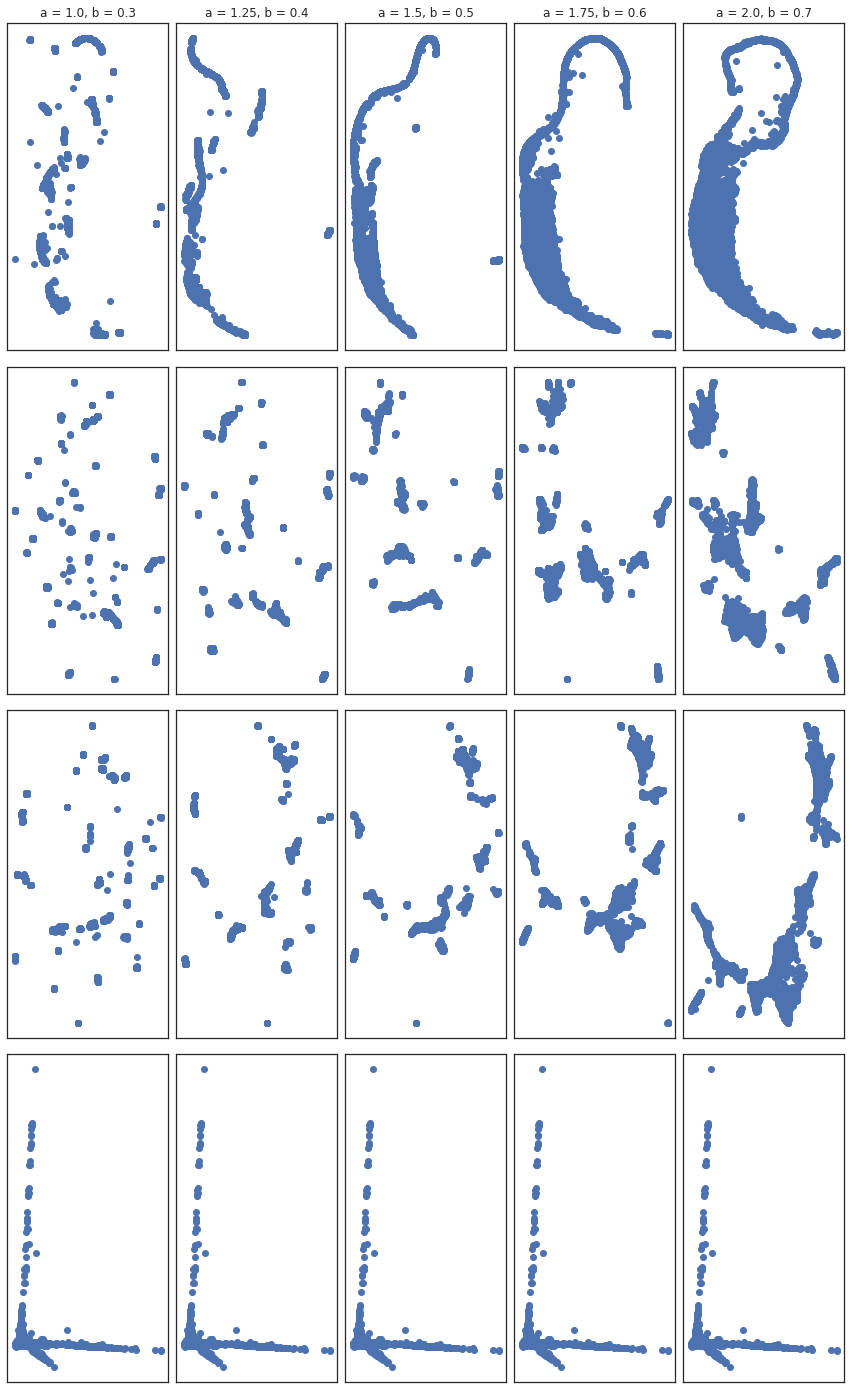

In [45]:
fig, axs = plt.subplots(4, 5, figsize=(15, 25))
projs = [precomputed_dep, precomputed_rho, precomputed_tnf, combined]
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
#         if i != 3:
        print(i, j)
#         projs[1][1]
        ax.scatter(
            projs[i][j].embedding_[:, 0],
            projs[i][j].embedding_[:, 1],
        )
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title("a = {}, b = {}".format(a[j], b[j]))
    #         if i == 0:
    #             ax.
#         else:
#             combine = projs[0][j] * projs[1][j] * projs[2][j] 
#             ax.scatter(
#                 combine.embedding_[:, 0],
#                 combine.embedding_[:, 1],
#             )
#             ax.set_xticks([])
#             ax.set_yticks([])

plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [58]:
idx = binner_ret.large_contigs.index[binner_ret.large_contigs['tid'] == 6125][0]
min_connections = 5
print(idx)
print(binner_ret.large_contigs[binner_ret.large_contigs['tid'] == 234]['contigName'])
print(index_md.neighbor_graph[0][idx, 0:min_connections], index_md.neighbor_graph[1][idx, 0:min_connections])
print(index_rho.neighbor_graph[0][idx, 1:min_connections], index_rho.neighbor_graph[1][idx, 1:min_connections])
print(index_euc.neighbor_graph[0][idx, 1:min_connections], index_euc.neighbor_graph[1][idx, 1:min_connections])
print(set(index_md.neighbor_graph[0][idx, 1:min_connections]).intersection(index_rho.neighbor_graph[0][idx, 1:min_connections], index_euc.neighbor_graph[0][idx, 1:min_connections]))
print(set(index_rho.neighbor_graph[0][idx, 1:min_connections]).intersection(index_euc.neighbor_graph[0][idx, 1:min_connections]))
print(binner_ret.large_contigs[binner_ret.large_contigs['tid'].isin(set(index_rho.neighbor_graph[0][idx, 1:min_connections]).intersection(index_euc.neighbor_graph[0][idx, 1:min_connections]))])

6125
234    contig_124_pilon
Name: contigName, dtype: object
[6125 4900 2613 6226 1654] [9.8814644e-07 2.6900021e-02 2.9026026e-02 3.2433536e-02 3.5105385e-02]
[ 603 6123 6040 1499] [0.02147062 0.02278464 0.0229055  0.02351994]
[ 603 1499 6123 6040] [3.541763  3.698641  3.7642791 3.7756333]
set()
{6040, 603, 1499, 6123}
             contigName  contigLen  totalAvgDepth  \
603   contig_1638_pilon    1026858      10.359647   
1499  contig_2599_pilon       3133       8.961075   
6040  contig_7020_pilon      13681       8.111635   
6123    contig_73_pilon       9856       5.475058   

      final_contigs.fasta/SB8775_S42_R1_001.fastq.gz.bam  \
603                                              2.2247    
1499                                             1.8458    
6040                                             2.0313    
6123                                             0.8954    

      final_contigs.fasta/SB8775_S42_R1_001.fastq.gz.bam-var  \
603                                            

In [60]:
binner_ega.nX(75)

NameError: name 'binner_ega' is not defined

In [ ]:
print(np.argwhere(index_md.neighbor_graph[0][0] == 0))
print(len(index_md.neighbor_graph[0][0]))
print(len(index_euc.neighbor_graph[0][0]))
print(index_md.neighbor_graph)
print(index_euc.neighbor_graph)
print(index_rho.neighbor_graph)

In [12]:
# from flight import metrics
import importlib
importlib.reload(metrics)
contig_1, _, _ = binner_ret.extract_contigs([85])
contig_2, _, _ = binner_ret.extract_contigs([179])
print(contig_1.values[:, 3:])

metrics.metabat_distance(contig_1.iloc[:, 3:].values[0], contig_1.iloc[:, 3:].values[0], 2, binner_ret.short_sample_distance)

[[3.0668 6.9267 25.94451 30.923761]]


9.881464487142724e-07

In [453]:
print(gm.means_.argmax())
gm.covariances_[gm.means_.argmax()][0][0]
gm.covariances_[gm.means_.argmin()][0][0]

1


0.016620193645210647

In [71]:
# sp_stats.mstats.gmean(log_lengths)
test_length = np.log10(3888)
idx25, n25 = binner_ret.nX(25)
idx75, n75 = binner_ret.nX(75)
print(n25, n75)
# dist1 = sp_stats.skewnorm(np.log10(n25), max(min_sum / count, np.log10(5000)), 1 + min_covar / count)
# dist2 = sp_stats.skewnorm(np.log10(n75), max_sum / count, 1 + max_covar / count)
dist1 = sp_stats.skewnorm(np.log10(n25), max(min_sum / count, np.log10(5000)), 1 + 0.01)
dist2 = sp_stats.skewnorm(np.log10(n75), max_sum / count, 1 + 0.229)
prob1 = dist1.pdf(test_length)
prob2 = dist2.pdf(test_length)
print(prob1)
print(prob2)
print("Rho and MD thresh:", max(prob1, prob2) / 2)
print("Euc thresh:       ", max(prob1, prob2) * 10)
# print(max(prob1, prob2) * 15)

29182 1155385
0.24683401307452024
0.0007483638509804313
Rho and MD thresh: 0.12341700653726012
Euc thresh:        2.4683401307452026


In [59]:
print(n75)
10**(max_sum / count)

1155385


15849.0265455096

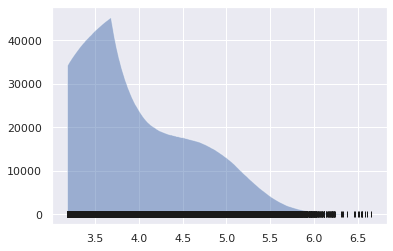

In [34]:
x_d = np.linspace(log_lengths.min(), log_lengths.max(), 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in log_lengths)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(log_lengths, np.full_like(log_lengths, -0.1), '|k', markeredgewidth=1)

In [ ]:
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=KFold(5))
grid.fit(log_lengths.values.reshape(-1, 1))
grid.best_params_

In [14]:
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=grid.best_params_['bandwidth'], kernel='gaussian')
kde.fit(log_lengths.values.reshape(-1, 1))

# score_samples returns the log of the probability density
logprob = kde.score_samples(log_lengths.values.reshape(-1, 1))

# plt.fill_between(log_lengths.values.reshape(-1, 1), np.exp(logprob), alpha=0.5)
plt.plot(log_lengths.values.reshape(-1, 1), np.full_like(log_lengths.values.reshape(-1, 1), -0.01), '|k', markeredgewidth=1)


NameError: name 'grid' is not defined